# RGB画像からのポットの抽出

In [28]:
import cv2
import numpy as np

In [29]:
im = cv2.imread('../data/2021-03-23T00-15-54.540456_color_image.png')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [30]:
import matplotlib.pyplot as plt

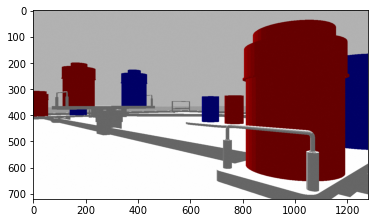

In [31]:
plt.imshow(im)
plt.show()

# RGBからHSVへ変換, 赤色の抽出

In [32]:
hsv = cv2.cvtColor(im, cv2.COLOR_RGB2HSV_FULL)
h = hsv[:, :, 0]
s = hsv[:, :, 1]

Hue(色相), Saturation(彩度)より赤色領域をマスク

In [33]:
mask = np.zeros(h.shape, dtype=np.uint8)
mask[((h < 20) | (h > 200)) & (s > 128)] = 255

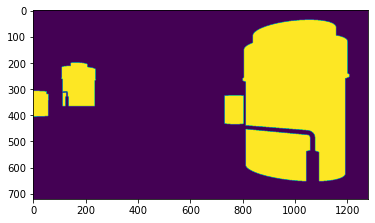

In [34]:
plt.imshow(mask)
plt.show()

# 膨張、収縮処理によりポールを消す

In [35]:
kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(25,25))
mask = cv2.dilate(mask,kernel,iterations = 1)
mask = cv2.erode(mask,kernel,iterations = 1)

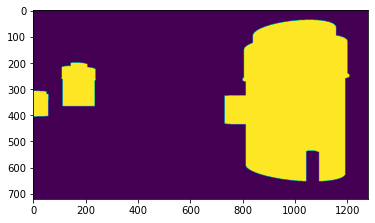

In [36]:
plt.imshow(mask)
plt.show()

フィルタサイズによって消せるポールのサイズは変化する。
また、この処理によって隣接するポットが結合してしまうことも

# マスク領域の輪郭を抽出

In [37]:
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

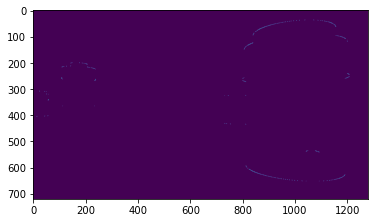

In [38]:
display = np.zeros(mask.shape, dtype=np.uint8)
for c in contours:
    for elem in c:
        display[elem[0,1],elem[0,0]]=255
plt.imshow(display)
plt.show()

# 輪郭を凸包で囲み、凸包を囲む矩形領域を抽出

In [39]:
rects = []
for contour in contours:
    approx = cv2.convexHull(contour)
    rect = cv2.boundingRect(approx)
    rects.append(rect)

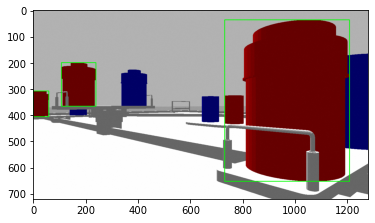

In [40]:
for rect in rects:
    x, y, w, h = rect
    cv2.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), thickness=2)
plt.imshow(im)
plt.show()

Depth画像ではこの矩形領域内を探索する

# Depth画像からポットの位置を推定

In [41]:
dep = cv2.imread('../data/2021-03-23T00-16-59.366620_depth_image.tiff')

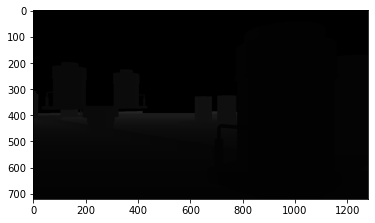

In [42]:
plt.imshow(dep)
plt.show()

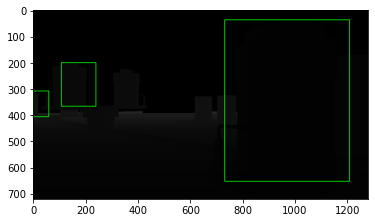

In [58]:
dep_cp = dep.copy()
for rect in rects:
    x, y, w, h = rect
    cv2.rectangle(dep_cp, (x, y), (x + w, y + h), (0, 255, 0), thickness=2)
plt.imshow(dep_cp)
plt.show()

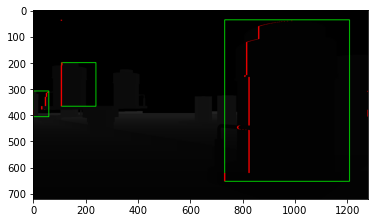

In [95]:
#table = np.zeros_like(dep)
im_cp = im.copy()
for rect in rects:
    x, y, w, h = rect
    for i in range(y,y+h):
        res = 1e9
        for j in range(x,x+w):
            if res > dep[i][j][0] and dep[i][j][0]!=0:
                res = dep[i][j][0]
                max_x_ind = j
            #table[i][j]=255
        dep_cp[i][max_x_ind] = [255,0,0]
        dep_cp[i][max_x_ind+1] = [255,0,0]
        dep_cp[i][max_x_ind+2] = [255,0,0]
        dep_cp[i][max_x_ind-1] = [255,0,0]
        dep_cp[i][max_x_ind-2] = [255,0,0]

        im_cp[i][max_x_ind] = [255,255,0]
        im_cp[i][max_x_ind+1] = [255,255,0]
        im_cp[i][max_x_ind+2] = [255,255,0]
        im_cp[i][max_x_ind-1] = [255,255,0]
        im_cp[i][max_x_ind-2] = [255,255,0]

plt.imshow(dep_cp)
plt.show()

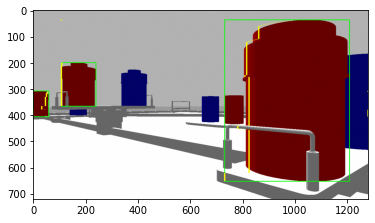

In [96]:
plt.imshow(im_cp)
plt.show()

何か微妙な気がする